In [2]:
from transformers import pipeline
from germansentiment import SentimentModel
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings('ignore')
tqdm.pandas()
sns.set_theme()

/Users/emilfunke/ETH/Master/semester_12/big-data-for-public-policy-2023/big_data_public_policy/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/emilfunke/ETH/Master/semester_12/big-data-for-public-policy-2023/big_data_public_policy/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Loading and Preprocessing of Swissvotes Dataset 

In [3]:
data = pd.read_excel('./data/DATASET XLSX 06-07-2023.xlsx', sheet_name='DATA')

In [4]:
data

,anr,datum,titel_kurz_d,titel_kurz_f,titel_off_d,titel_off_f,stichwort,swissvoteslink,anzahl,rechtsform,...,ju-nein,ju-japroz,ju-annahme,bkresults-de,bkresults-fr,bfsmap-de,bfsmap-fr,nach_cockpit_d,nach_cockpit_f,nach_cockpit_e
0,1.0,12.09.1848,Bundesverfassung der schweizerischen Eidgenoss...,Constitution fédérale de la Confédération suisse,Totalrevision vom 12. September 1848,Révision totale du 12 septembre 1848,.,https://swissvotes.ch/vote/1.00,1,1,...,.,.,.,https://www.bk.admin.ch/ch/d/pore/va/18480606/...,https://www.bk.admin.ch/ch/f/pore/va/18480606/...,NaN,NaN,.,.,.
1,2.0,14.01.1866,Mass und Gewicht,Poids et mesures,Festsetzung von Mass und Gewicht,Poids et mesures,.,https://swissvotes.ch/vote/2.00,9,1,...,.,.,.,https://www.bk.admin.ch/ch/d/pore/va/18660114/...,https://www.bk.admin.ch/ch/f/pore/va/18660114/...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,.,.,.
2,3.0,14.01.1866,Gleichstellung der Juden und Naturalisierten m...,Egalité des Juifs,Gleichstellung der Juden und Naturalisierten m...,Egalité des citoyens au point de vue de l'étab...,.,https://swissvotes.ch/vote/3.00,9,1,...,.,.,.,https://www.bk.admin.ch/ch/d/pore/va/18660114/...,https://www.bk.admin.ch/ch/f/pore/va/18660114/...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,.,.,.
3,4.0,14.01.1866,Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",.,https://swissvotes.ch/vote/4.00,9,1,...,.,.,.,https://www.bk.admin.ch/ch/d/pore/va/18660114/...,https://www.bk.admin.ch/ch/f/pore/va/18660114/...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,.,.,.
4,5.0,14.01.1866,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,.,https://swissvotes.ch/vote/5.00,9,1,...,.,.,.,https://www.bk.admin.ch/ch/d/pore/va/18660114/...,https://www.bk.admin.ch/ch/f/pore/va/18660114/...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,.,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,660.0,2022-09-25 00:00:00,AHV-Gesetz (AHV 21),Loi sur l’AVS (AVS 21),Änderung des Bundesgesetzes über die Alters- u...,Modification de la loi fédérale sur l’assuranc...,Frauenrentenalter 65,https://swissvotes.ch/vote/660.00,4,2,...,20057,29.119695,0,https://www.bk.admin.ch/ch/d/pore/va/20220925/...,https://www.bk.admin.ch/ch/f/pore/va/20220925/...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,NaN,NaN,NaN
679,661.0,2022-09-25 00:00:00,Verrechnungssteuergesetz,Loi sur l’impôt anticipé,Änderung des Bundesgesetzes über die Verrechnu...,Modification de la loi fédérale sur l’impôt an...,.,https://swissvotes.ch/vote/661.00,4,2,...,17265,36.029493,0,https://www.bk.admin.ch/ch/d/pore/va/20220925/...,https://www.bk.admin.ch/ch/f/pore/va/20220925/...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,NaN,NaN,NaN
680,662.0,2023-06-18 00:00:00,OECD-Mindeststeuer für Unternehmen,Imposition minimale de l'OCDE,Bundesbeschluss über eine besondere Besteuerun...,Arrêté fédéral sur une imposition particulière...,.,https://swissvotes.ch/vote/662.00,3,1,...,NaN,NaN,1,https://www.bk.admin.ch/ch/d/pore/va/20230618/...,https://www.bk.admin.ch/ch/f/pore/va/20230618/...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,https://www.atlas.bfs.admin.ch/maps/12/map/map...,NaN,NaN,NaN
681,663.0,2023-06-18 00:00:00,Klimagesetz,Loi sur le climat,"Bundesgesetz über die Ziele im Klimaschutz, di...",Loi fédérale sur les objectifs en matière de p...,"Klimaschutzgesetz, «Stromfressergesetz»",https://swissvo

## Preprocessing oucome analysis for German and French Cantons

In [5]:
def get_german_outcome(row):
    #row = row.fillna(0)
    row = row.replace('.', np.nan)
    yes = sum(row[['sh-ja', 'tg-ja', 'lu-ja', 'sz-ja', 'zh-ja', 'be-ja', 'gr-ja', 'gl-ja', 'so-ja', 'ag-ja', 'bl-ja', 'bs-ja', 'ow-ja', 'nw-ja', 'sg-ja', 'ur-ja']])
    no = sum(row[['sh-nein', 'tg-nein', 'lu-nein', 'sz-nein', 'zh-nein', 'be-nein', 'gr-nein', 'gl-nein', 'so-nein', 'ag-nein', 'bl-nein', 'bs-nein', 'ow-nein', 'nw-nein', 'sg-nein', 'ur-nein']])
    if yes == 0 or no == 0:
        return int((sum(row[['sh-annahme', 'tg-annahme', 'lu-annahme', 'sz-annahme', 'zh-annahme', 'be-annahme', 'gr-annahme', 'gl-annahme', 'so-annahme', 'ag-annahme', 'bl-annahme', 'bs-annahme', 'ow-annahme', 'nw-annahme', 'sg-annahme', 'ur-annahme']])/16) > 0.5), yes , no
    if yes > no:
        return 1, yes, no
    else:
        return 0, yes, no


def get_fr_outcome(row):
    #substitute . with 0 and np.nan with 0 in order to be able to sum
    #row = row.fillna(0)
    row = row.replace('.', np.nan)
    yes = sum(row[['fr-ja', 'ge-ja', 'vs-ja', 'vd-ja', 'ne-ja', 'ju-ja']])
    no = sum(row[['fr-nein', 'ge-nein', 'vs-nein', 'vd-nein', 'ne-nein', 'ju-nein']])
    if yes == 0 or no == 0:
        return int((sum(row[['fr-annahme', 'ge-annahme', 'vs-annahme', 'vd-annahme', 'ne-annahme', 'ju-annahme']])/6) > 0.5), yes , no
    if yes > no:
        return 1, yes, no
    else:
        return 0, yes, no

In [6]:
data['german_outcome'] = data.apply(lambda x: get_german_outcome(x)[0], axis=1)
data['french_outcome'] = data.apply(lambda x: get_fr_outcome(x)[0], axis=1)
data['german_yes'] = data.apply(lambda x: get_german_outcome(x)[1], axis=1)
data['german_no'] = data.apply(lambda x: get_german_outcome(x)[2], axis=1)
data['french_yes'] = data.apply(lambda x: get_fr_outcome(x)[1], axis=1)
data['french_no'] = data.apply(lambda x: get_fr_outcome(x)[2], axis=1)

# Data Exploration

In [7]:
annahme_columns = [col for col in data.columns if 'annahme' in col]
annahme_data = data[annahme_columns]
annahme_data.fillna(100, inplace=True)
annahme_data.replace('.', 100, inplace=True)

counts = annahme_data.apply(pd.Series.value_counts)
ratios = counts.loc[1] / counts.loc[0]
ratios.sort_values(ascending=False, inplace=True)

top = ratios.head(3)
bottom = ratios.tail(3)

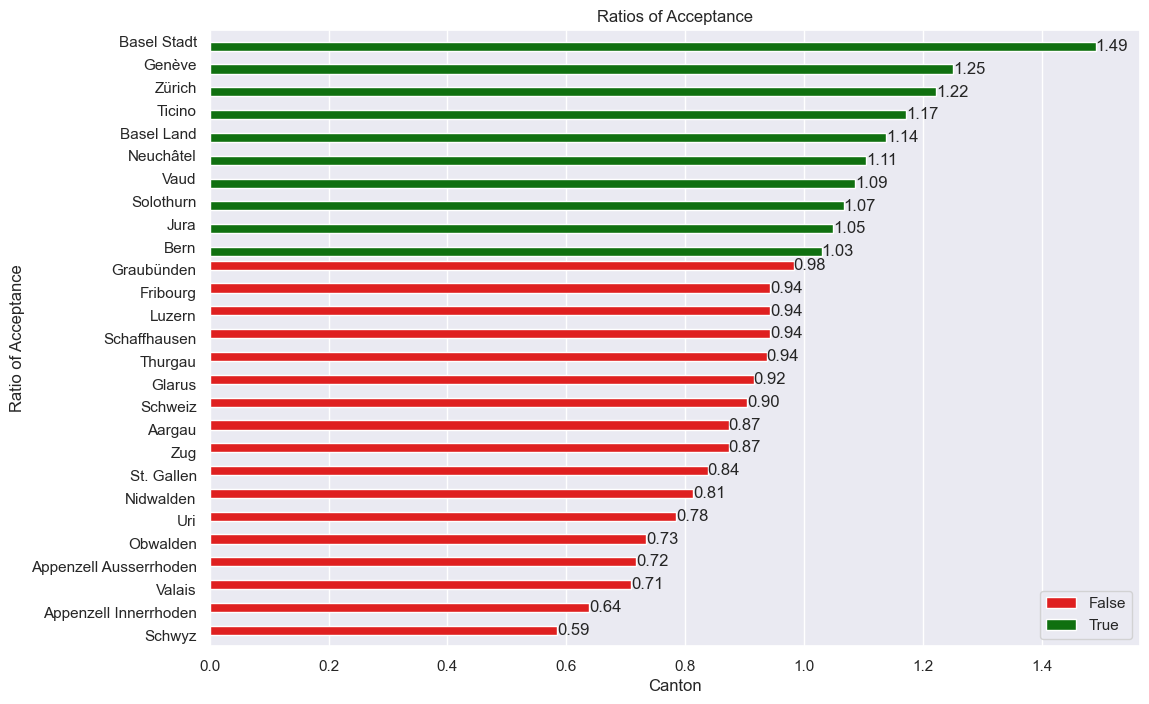

In [8]:
fig, axs = plt.subplots(figsize=(12,8))
sns.barplot(y=ratios.index, x=ratios.values, ax=axs, hue=ratios.values>1, palette=['red', 'green'])
axs.set_title('Ratios of Acceptance')
axs.set_ylabel('Ratio of Acceptance')
axs.set_xlabel('Canton')
axs.set_yticklabels(['Basel Stadt', 'Genève', 'Zürich', 'Ticino', 'Basel Land', 'Neuchâtel', 'Vaud', 'Solothurn', 'Jura', 'Bern', 'Graubünden', 'Fribourg', 'Luzern', 'Schaffhausen', 'Thurgau', 'Glarus', 'Schweiz', 'Aargau', 'Zug', 'St. Gallen', 'Nidwalden', 'Uri', 'Obwalden', 'Appenzell Ausserrhoden', 'Valais', 'Appenzell Innerrhoden', 'Schwyz'])
for i in axs.containers:
    axs.bar_label(i, fmt='%.2f', label_type='edge')
#plt.savefig('./figures/acceptance_ratios_tot.pdf', format='pdf', bbox_inches='tight')

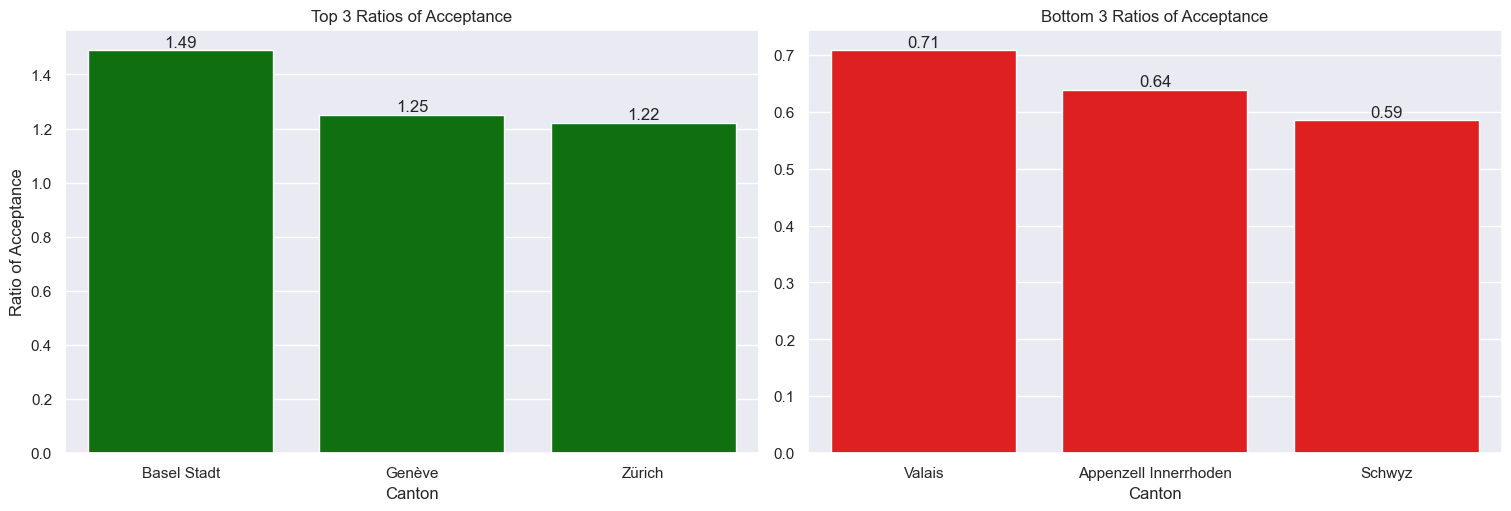

In [9]:
fig, axs = plt.subplots(nrows=1,ncols=2, layout='constrained',figsize=(15,5))
sns.barplot(x=top.index, y=top.values, ax=axs[0], color='green')
axs[0].set_title('Top 3 Ratios of Acceptance')
axs[0].set_ylabel('Ratio of Acceptance')
axs[0].set_xlabel('Canton')
axs[0].set_xticklabels(['Basel Stadt', 'Genève', 'Zürich'])
for i in axs[0].containers:
    axs[0].bar_label(i, fmt='%.2f', label_type='edge')

sns.barplot(x=bottom.index, y=bottom.values, ax=axs[1], color='red')
axs[1].set_title('Bottom 3 Ratios of Acceptance')
axs[1].set_xlabel('Canton')
axs[1].set_xticklabels(['Valais', 'Appenzell Innerrhoden', 'Schwyz'])
for i in axs[1].containers:
    axs[1].bar_label(i, fmt='%.2f', label_type='edge')
#plt.savefig('./figures/acceptance_ratios3.pdf', format='pdf', bbox_inches='tight')

In [10]:
beteiligung_columns = [col for col in data.columns if 'bet' in col]
beteiligung_columns.append('anr')
beteiligung_data = data[beteiligung_columns]
beteiligung_data.drop(columns=['kurzbetitel'], inplace=True)
beteiligung_data.replace('.', np.nan, inplace=True)

In [11]:
dfm = beteiligung_data[['bet', 'zh-bet', 'ge-bet', 'sz-bet', 'anr']].melt('anr', var_name='cols', value_name='vals')

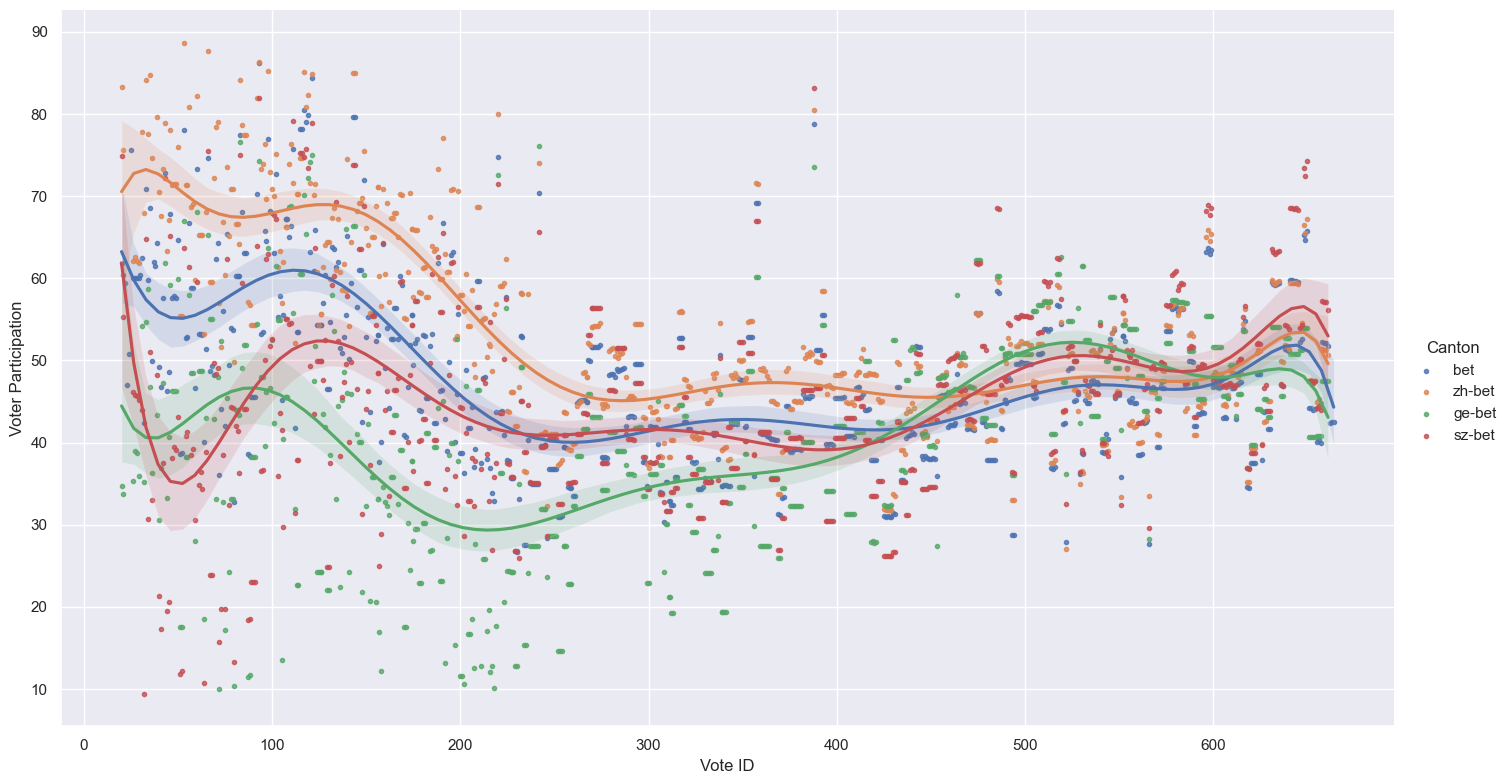

In [12]:
#fig, axs = plt.subplots(figsize=(24,12))
g = sns.lmplot(x='anr', y='vals', data=dfm, hue='cols', order=10, scatter=True, markers=[".", ".", ".", "."], height=8, aspect=1.7777777)
g.set_ylabels('Voter Participation')
g.set_xlabels('Vote ID')
g._legend.set_title('Canton')
#plt.savefig('./figures/beteiligung.pdf', format='pdf', bbox_inches='tight')

# Sentiment Analysis

In [13]:
text_data = data[['anr', 'datum', 'titel_kurz_d', 'titel_kurz_f', 'titel_off_d', 'titel_off_f', 'german_outcome', 'french_outcome', 'german_yes', 'german_no', 'french_yes', 'french_no']]

## Sentiment Analysis Seperate for German and French Vote Titles

### Similarity between German and French Vote Titles

In [14]:
model_similarity = SentenceTransformer('distiluse-base-multilingual-cased-v1')
def get_title_similarity(row):
    german_embedding = model_similarity.encode([row['titel_off_d']])
    french_embedding = model_similarity.encode([row['titel_off_f']])
    similarity = cosine_similarity(german_embedding, french_embedding)[0][0]
    return similarity

In [15]:
text_data['title_similarity'] = text_data.progress_apply(get_title_similarity, axis=1)

  0%|          | 0/683 [00:00<?, ?it/s]

100%|██████████| 683/683 [00:30<00:00, 22.22it/s]


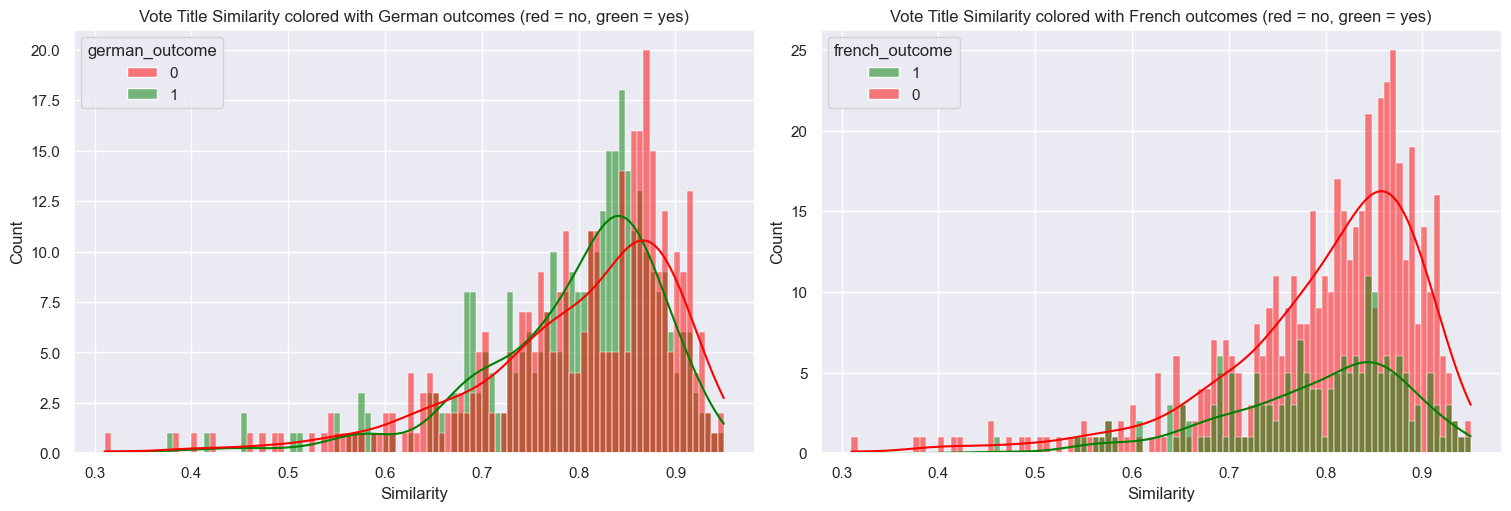

In [16]:
fig, axs = plt.subplots(nrows=1,ncols=2, layout='constrained',figsize=(15,5))
sns.histplot(data=text_data, x='title_similarity', bins=100, ax=axs[0], hue='german_outcome', palette=['red', 'green'], kde=True)
axs[0].set_title('Vote Title Similarity colored with German outcomes (red = no, green = yes)')
axs[0].set_xlabel('Similarity')
axs[0].set_ylabel('Count')
sns.histplot(data=text_data, x='title_similarity', bins=100, ax=axs[1], hue='french_outcome', palette=['green', 'red'], hue_order=[1, 0], kde=True)
axs[1].set_title('Vote Title Similarity colored with French outcomes (red = no, green = yes)')
axs[1].set_xlabel('Similarity')
#plt.savefig('./figures/title_similarity.pdf', format='pdf', bbox_inches='tight')

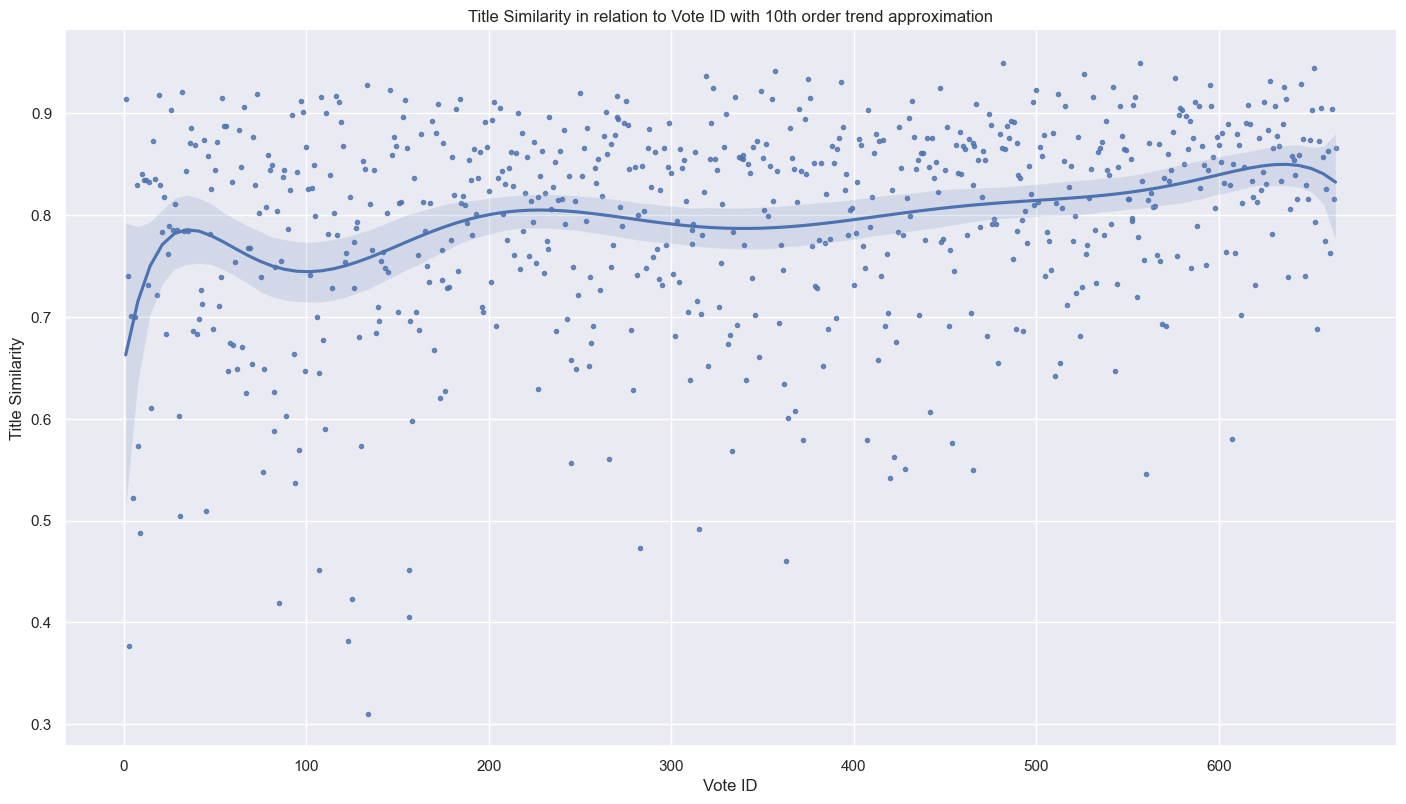

In [17]:
g = sns.lmplot(data=text_data, x='anr', y='title_similarity', order=10, scatter=True, markers=["."], height=8, aspect=1.7777777)
g.set_ylabels('Title Similarity')
g.set_xlabels('Vote ID')
plt.title('Title Similarity in relation to Vote ID with 10th order trend approximation')
#plt.savefig('./figures/title_similarity_trend.pdf', format='pdf', bbox_inches='tight')

In [18]:
sorted = text_data.sort_values(by='title_similarity', ascending=False)

In [19]:
sorted.head()

,anr,datum,titel_kurz_d,titel_kurz_f,titel_off_d,titel_off_f,german_outcome,french_outcome,german_yes,german_no,french_yes,french_no,title_similarity
575,557.0,2012-03-11 00:00:00,Initiative «6 Wochen Ferien für alle»,Initiative «6 semaines de vacances pour tous»,Volksinitiative «6 Wochen Ferien für alle»,Initiative populaire «6 semaines de vacances p...,0,0,466080.0,1066010.0,247699.0,372246.0,0.949911
496,482.0,2001-12-02 00:00:00,Initiative für eine Schweiz ohne Armee,Initiative pour une Suisse sans armée,Volksinitiative «für eine glaubwürdige Sicherh...,Initiative populaire «pour une politique de sé...,0,0,252121.0,1020486.0,109599.0,266161.0,0.949429
670,652.0,2022-02-13 00:00:00,Initiative «Kinder und Jugendliche ohne Tabakw...,Initiative «Enfants et jeunes sans publicité p...,Volksinitiative «Ja zum Schutz der Kinder und ...,Initiative populaire «Oui à la protection des ...,1,1,928208.0,789038.0,357930.0,186080.0,0.944127
369,357.0,1989-11-26 00:00:00,Initiative für eine Schweiz ohne Armee,Initiative pour une Suisse sans armée,Volksinitiative «für eine Schweiz ohne Armee u...,Initiative populaire «pour une Suisse sans arm...,0,0,741304.0,1413584.0,244631.0,377184.0,0.941548
542,526.0,2006-11-26 00:00:00,Gesetz über die Zusammenarbeit mit den Staaten...,Loi sur la coopération avec l’Europe de l’Est,Bundesgesetz über die Zusammenarbeit mit den S...,Loi fédérale sur la coopération avec les Etats...,1,1,785047.0,706281.0,313205.0,223021.0,0.938329


In [20]:
analyzer_fr = pipeline(
    task='text-classification',
    model="cmarkea/distilcamembert-base-sentiment",
    tokenizer="cmarkea/distilcamembert-base-sentiment")
model_de = SentimentModel()

def get_fr_sentiment(text):
    result = analyzer_fr(text, return_all_scores=True)
    res = 0
    for i in range(len(result[0])):
        if i < 2:
            res -= result[0][i]['score']
        elif i==2:
            continue
        elif i > 2:
            res += result[0][i]['score']
    return res
def get_de_sentiment(text):
    res = 0
    classes, probabilities = model_de.predict_sentiment([text], output_probabilities=True)
    for i in range(len(probabilities[0])):
        if i == 0:
            res += probabilities[0][i][1]
        elif i==1:
            res -= probabilities[0][i][1]
        elif i == 2:
            continue
    return res

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [21]:
tqdm.pandas()
text_data['sentiment_d'] = text_data['titel_off_d'].progress_apply(get_de_sentiment)
text_data['sentiment_fr'] = text_data['titel_off_f'].progress_apply(get_fr_sentiment)

100%|██████████| 683/683 [00:13<00:00, 51.30it/s]


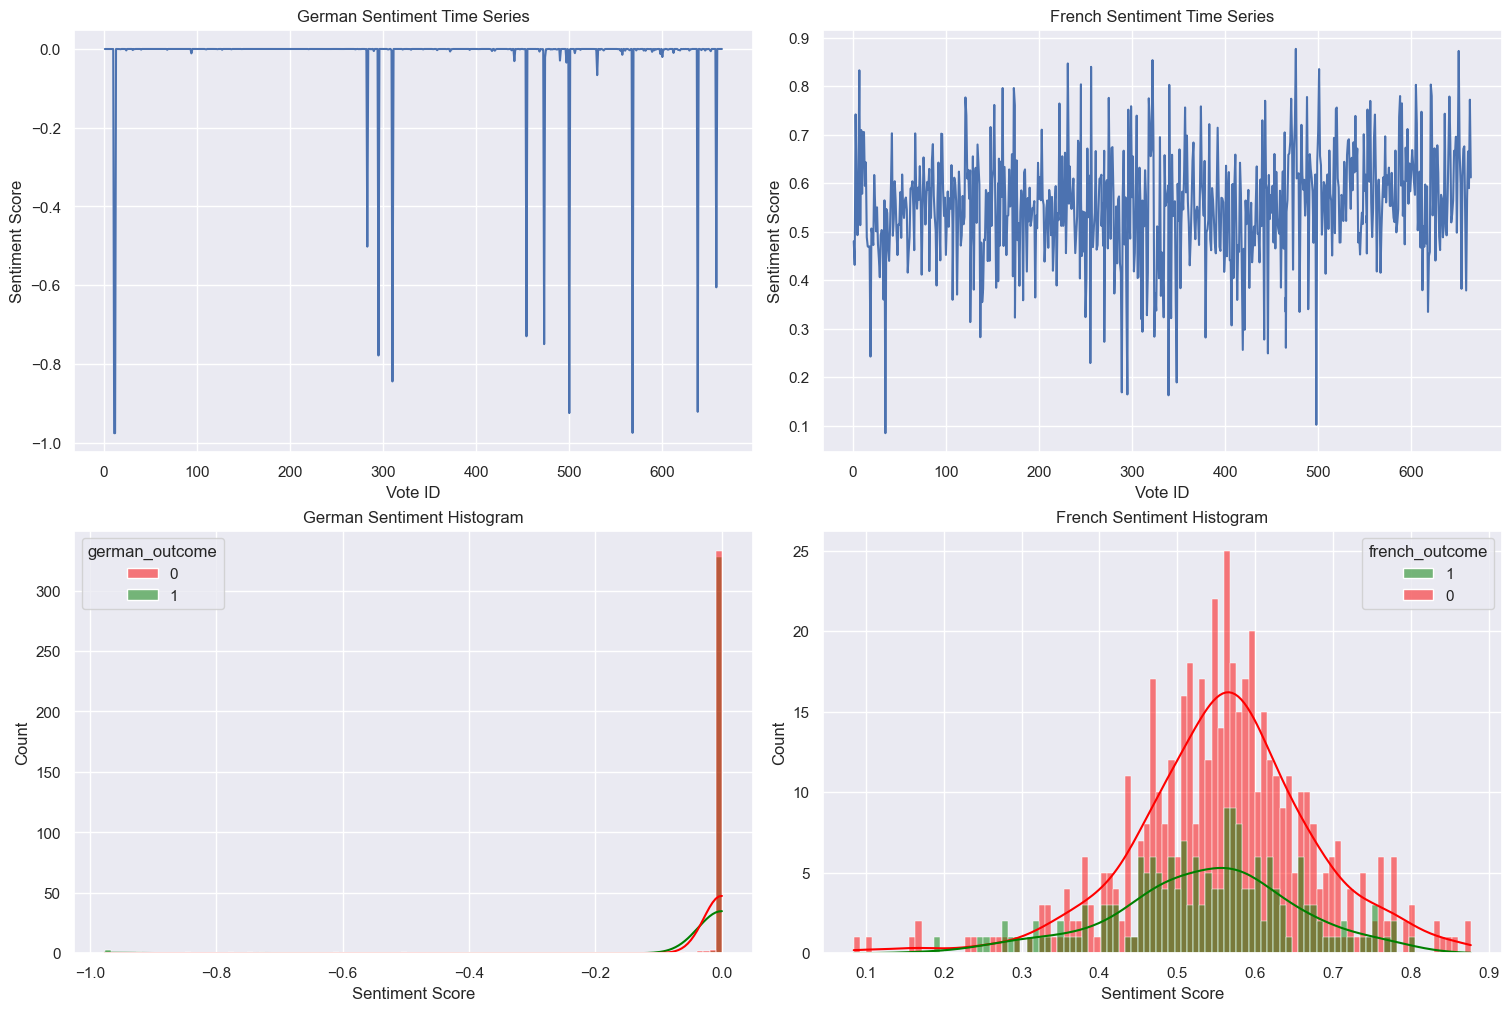

In [23]:
fig, axs = plt.subplots(nrows=2,ncols=2, layout='constrained',figsize=(15,10))
sns.lineplot(data=text_data, x='anr', y="sentiment_d", ax=axs[0][0])
axs[0][0].set_title('German Sentiment Time Series')
axs[0][0].set_xlabel('Vote ID')
axs[0][0].set_ylabel('Sentiment Score')
sns.lineplot(data=text_data, x='anr', y="sentiment_fr", ax=axs[0][1])
axs[0][1].set_title('French Sentiment Time Series')
axs[0][1].set_xlabel('Vote ID')
axs[0][1].set_ylabel('Sentiment Score')
sns.histplot(data=text_data, x='sentiment_d', bins=100, ax=axs[1][0], hue='german_outcome', palette=['red', 'green'], kde=True)
axs[1][0].set_title('German Sentiment Histogram')
axs[1][0].set_xlabel('Sentiment Score')
axs[1][0].set_ylabel('Count')
sns.histplot(data=text_data, x='sentiment_fr', bins=100, ax=axs[1][1], hue='french_outcome', palette=['green', 'red'], hue_order=[1, 0], kde=True)
axs[1][1].set_title('French Sentiment Histogram')
axs[1][1].set_xlabel('Sentiment Score')
#axs[1][1].set_ylabel('Count')
#plt.savefig('./figures/sentiment_seperate.pdf', format='pdf', bbox_inches='tight')

In [24]:
sentiment = pipeline(task="sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
def get_bert_label(text):
    return sentiment(text)[0]['label']
def get_bert_score(text):
    tmp_sentiment = sentiment(text, return_all_scores=True)
    return -tmp_sentiment[0][0]['score']-tmp_sentiment[0][1]['score']+tmp_sentiment[0][3]['score']+tmp_sentiment[0][4]['score']
def get_bert(text):
    return sentiment(text)[0]

In [25]:
text_data['sentiment_d_bert_label'] = text_data['titel_off_d'].progress_apply(get_bert_label)
text_data['sentiment_fr_bert_label'] = text_data['titel_off_f'].progress_apply(get_bert_label)
text_data['sentiment_d_bert_score'] = text_data['titel_off_d'].progress_apply(get_bert_score)
text_data['sentiment_fr_bert_score'] = text_data['titel_off_f'].progress_apply(get_bert_score)

100%|██████████| 683/683 [00:26<00:00, 25.67it/s]


In [26]:
text_data.head(10)

,anr,datum,titel_kurz_d,titel_kurz_f,titel_off_d,titel_off_f,german_outcome,french_outcome,german_yes,german_no,french_yes,french_no,title_similarity,sentiment_d,sentiment_fr,sentiment_d_bert_label,sentiment_fr_bert_label,sentiment_d_bert_score,sentiment_fr_bert_score
0,1.0,12.09.1848,Bundesverfassung der schweizerischen Eidgenoss...,Constitution fédérale de la Confédération suisse,Totalrevision vom 12. September 1848,Révision totale du 12 septembre 1848,0,0,NaN,NaN,NaN,NaN,0.913938,-0.000054,0.480089,1 star,1 star,-0.850861,-0.301526
1,2.0,14.01.1866,Mass und Gewicht,Poids et mesures,Festsetzung von Mass und Gewicht,Poids et mesures,0,0,109359.0,122755.0,NaN,NaN,0.739839,-0.000044,0.431590,4 stars,5 stars,0.690028,0.665731
2,3.0,14.01.1866,Gleichstellung der Juden und Naturalisierten m...,Egalité des Juifs,Gleichstellung der Juden und Naturalisierten m...,Egalité des citoyens au point de vue de l'étab...,1,0,121463.0,113453.0,NaN,NaN,0.376547,-0.000003,0.741770,4 stars,4 stars,0.378077,0.674073
3,4.0,14.01.1866,Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",0,0,116454.0,118203.0,NaN,NaN,0.701087,-0.000009,0.597496,4 stars,5 stars,0.572135,0.535506
4,5.0,14.01.1866,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,0,0,109031.0,122893.0,NaN,NaN,0.522434,-0.000011,0.492853,5 stars,5 stars,0.672129,0.500753
5,6.0,14.01.1866,Stimmrecht der Niedergelassenen in kantonalen ...,"Droit de vote des Suisses établis, en matière ...",Stimmrecht der Niedergelassenen in kantonalen ...,"Droit de vote des Suisses établis, en matière ...",1,0,122108.0,112788.0,NaN,NaN,0.700256,-0.000005,0.605837,4 stars,5 stars,0.465268,0.558619
6,7.0,14.01.1866,Glaubens- und Kultusfreiheit,Liberté de conscience et des cultes,Glaubens- und Kultusfreiheit,Liberté de conscience et des cultes,0,0,114067.0,119719.0,NaN,NaN,0.829270,0.000266,0.832642,5 stars,5 stars,0.838675,0.778392
7,8.0,14.01.1866,Ausschliessung einzelner Strafarten,Interdiction de certains genres de peines,Ausschliessung einzelner Strafarten,Interdiction de certains genres de peines,0,0,90482.0,142202.0,NaN,NaN,0.572884,-0.000210,0.513442,3 stars,1 star,0.144190,-0.565871
8,9.0,14.01.1866,Schutz des geistigen Eigentums,"Protection de la propriété littéraire, artisti...",Schutz des geistigen Eigentums,"Protection de la propriété littéraire, artisti...",0,0,110732.0,120427.0,NaN,NaN,0.488191,-0.000005,0.709514,5 stars,5 stars,0.741163,0.823532
9,10.0,14.01.1866,Verbot der Lotterie und Hasardspiele,Interdiction des loteries et jeux de hasard,Verbot der Lotterie und Hasardspiele,Interdiction des loteries et jeux de hasard,0,0,115219.0,116569.0,NaN,NaN,0.840769,-0.000143,0.578163,1 star,1 star,-0.588171,-0.517892


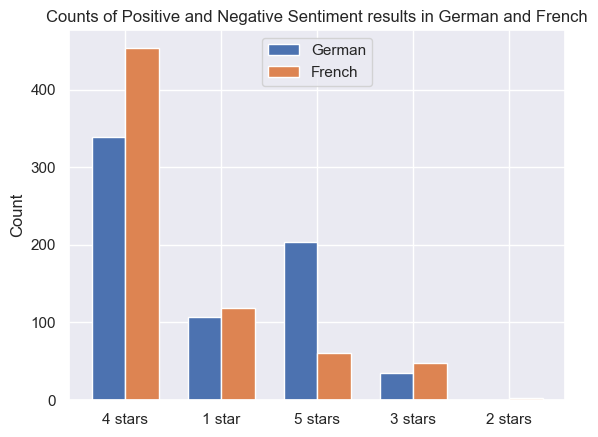

In [27]:
column1_counts = text_data['sentiment_d_bert_label'].value_counts()
column2_counts = text_data['sentiment_fr_bert_label'].value_counts()
if len(column1_counts) < len(column2_counts):
    column1_counts = column1_counts.reindex(column2_counts.index)
fig, ax = plt.subplots()
x = range(len(column1_counts))
width = 0.35

rects1 = ax.bar(x, column1_counts, width, label='German')
rects2 = ax.bar([i + width for i in x], column2_counts, width, label='French')

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(column1_counts.index)

ax.set_ylabel('Count')
ax.set_title('Counts of Positive and Negative Sentiment results in German and French')
ax.legend()

plt.show()


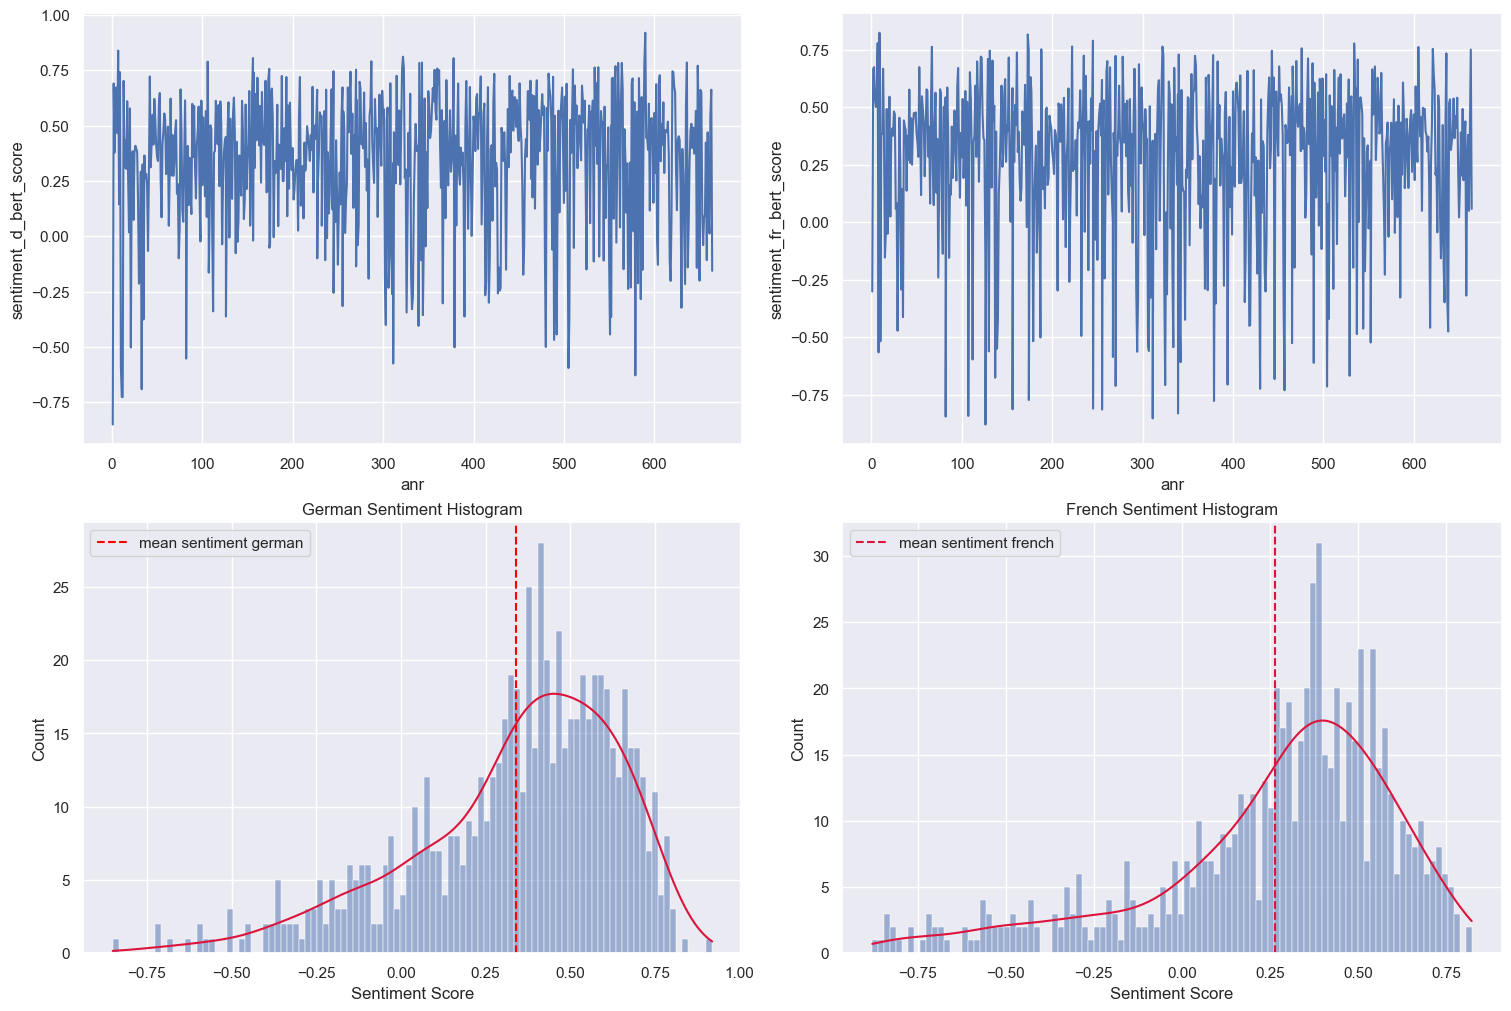

In [28]:
fig, axs = plt.subplots(nrows=2,ncols=2, layout='constrained',figsize=(15,10))
sns.lineplot(data=text_data, x='anr', y="sentiment_d_bert_score", ax=axs[0][0])
sns.lineplot(data=text_data, x='anr', y="sentiment_fr_bert_score", ax=axs[0][1])
sns.histplot(data=text_data, x='sentiment_d_bert_score', bins=100, ax=axs[1][0], kde=True)
axs[1][0].lines[0].set_color('crimson')
axs[1][0].set_title('German Sentiment Histogram')
axs[1][0].set_xlabel('Sentiment Score')
axs[1][0].set_ylabel('Count')
axs[1][0].axvline(x=text_data['sentiment_d_bert_score'].mean(), color='red', ls='--', label='mean sentiment german')
axs[1][0].legend()
sns.histplot(data=text_data, x='sentiment_fr_bert_score', bins=100, ax=axs[1][1], kde=True)
axs[1][1].lines[0].set_color('crimson')
axs[1][1].set_title('French Sentiment Histogram')
axs[1][1].set_xlabel('Sentiment Score')
axs[1][1].set_ylabel('Count')
axs[1][1].axvline(x=text_data['sentiment_fr_bert_score'].mean(), color='crimson', ls='--', label='mean sentiment french')
axs[1][1].legend()

<Axes: xlabel='anr', ylabel='sentiment_fr_bert_score'>

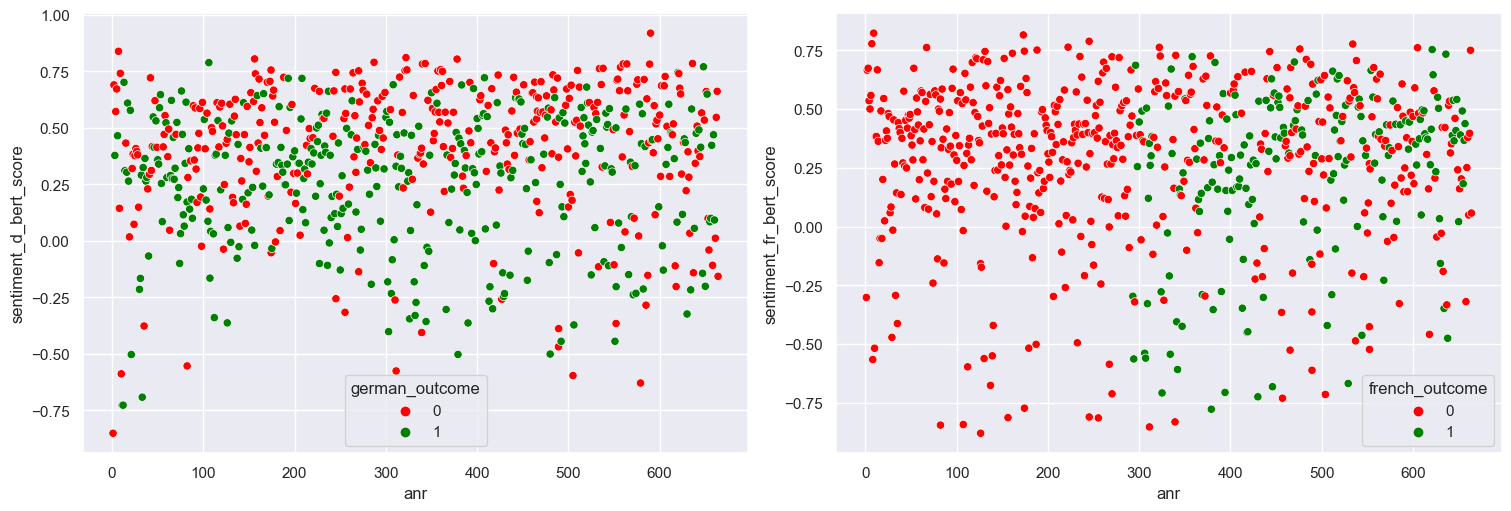

In [29]:
fig, axs = plt.subplots(nrows=1,ncols=2, layout='constrained',figsize=(15,5))
#sns.lineplot(data=text_data, x='anr', y="sentiment_d_bert_score", hue='german_outcome', ax=axs[0][0], palette=['red', 'green'])
#sns.lineplot(data=text_data, x='anr', y="sentiment_fr_bert_score", hue='french_outcome', ax=axs[0][1], palette=['red', 'green'])
sns.scatterplot(data=text_data, x='anr', y='sentiment_d_bert_score', hue='german_outcome', ax=axs[0], palette=['red', 'green'])
sns.scatterplot(data=text_data, x='anr', y='sentiment_fr_bert_score', hue='french_outcome', ax=axs[1], palette=['red', 'green'])

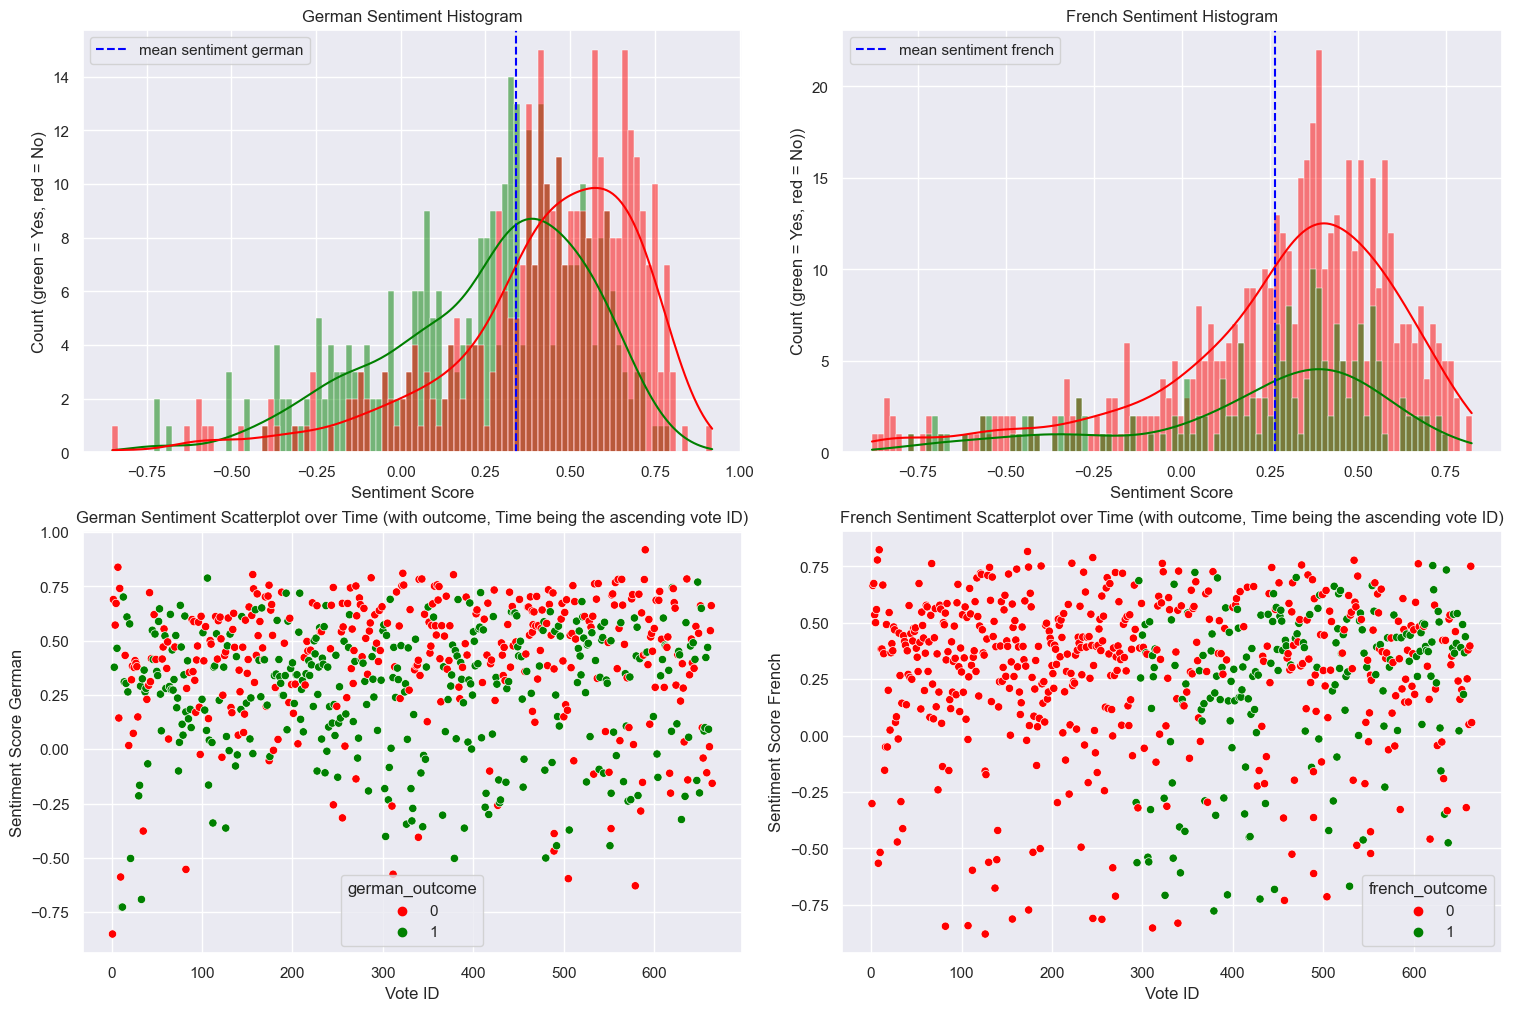

In [30]:
fig, axs = plt.subplots(nrows=2,ncols=2, layout='constrained',figsize=(15,10))

sns.histplot(data=text_data, x='sentiment_d_bert_score', bins=100, ax=axs[0][0], kde=True, hue='german_outcome', palette=['red', 'green'])
#axs[0][0].line[0][0].set_color('crimson')
axs[0][0].set_title('German Sentiment Histogram')
axs[0][0].set_xlabel('Sentiment Score')
axs[0][0].set_ylabel('Count (green = Yes, red = No)')
axs[0][0].axvline(x=text_data['sentiment_d_bert_score'].mean(), color='blue', ls='--', label='mean sentiment german')
axs[0][0].legend()
sns.histplot(data=text_data, x='sentiment_fr_bert_score', bins=100, ax=axs[0][1], kde=True, hue='french_outcome', hue_order=[1,0], palette=['green', 'red'])
#axs[0][1].lines[0].set_color('crimson')
axs[0][1].set_title('French Sentiment Histogram')
axs[0][1].set_xlabel('Sentiment Score')
axs[0][1].set_ylabel('Count (green = Yes, red = No))')
axs[0][1].axvline(x=text_data['sentiment_fr_bert_score'].mean(), color='blue', ls='--', label='mean sentiment french')
axs[0][1].legend()

sns.scatterplot(data=text_data, x='anr', y='sentiment_d_bert_score', hue='german_outcome', ax=axs[1][0], palette=['red', 'green'], legend='auto')
axs[1][0].set_title('German Sentiment Scatterplot over Time (with outcome, Time being the ascending vote ID)')
axs[1][0].set_xlabel('Vote ID')
axs[1][0].set_ylabel('Sentiment Score German')
sns.scatterplot(data=text_data, x='anr', y='sentiment_fr_bert_score', hue='french_outcome', ax=axs[1][1], palette=['red', 'green'], legend='auto')
axs[1][1].set_title('French Sentiment Scatterplot over Time (with outcome, Time being the ascending vote ID)')
axs[1][1].set_xlabel('Vote ID')
axs[1][1].set_ylabel('Sentiment Score French')


'''
sns.histplot(data=text_data, x='sentiment_d_textblob', bins=100, ax=axs[2][0], kde=True)
axs[2][0].lines[0].set_color('crimson')
axs[2][0].set_title('German Sentiment Histogram')
axs[2][0].set_xlabel('Sentiment Score')
axs[2][0].set_ylabel('Count')
axs[2][0].axvline(x=text_data['sentiment_d_textblob'].mean(), color='red', ls='--', label='mean sentiment german')
axs[2][0].legend()
sns.histplot(data=text_data, x='sentiment_fr_textblob', bins=100, ax=axs[2][1], kde=True)
axs[2][1].lines[0].set_color('crimson')
axs[2][1].set_title('French Sentiment Histogram')
axs[2][1].set_xlabel('Sentiment Score')
axs[2][1].set_ylabel('Count')
axs[2][1].axvline(x=text_data['sentiment_fr_textblob'].mean(), color='crimson', ls='--', label='mean sentiment french')
axs[2][1].legend()
'''
#plt.savefig('./figures/sentiment_bert.pdf', format='pdf', bbox_inches='tight')

In [31]:
text_data.describe()

,anr,german_outcome,french_outcome,german_yes,german_no,french_yes,french_no,title_similarity,sentiment_d,sentiment_fr,sentiment_d_bert_score,sentiment_fr_bert_score
count,683.000000,683.000000,683.000000,6.790000e+02,6.790000e+02,377.000000,377.00000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,331.755051,0.493411,0.269400,5.442449e+05,5.597465e+05,224466.917772,236768.29443,0.796655,-0.013814,0.552781,0.338586,0.264931
std,190.815783,0.500323,0.443973,3.246372e+05,3.649983e+05,107520.833838,118137.99174,0.100711,0.104699,0.115548,0.308108,0.347160
min,1.000000,0.000000,0.000000,1.314200e+04,2.099500e+04,33790.000000,19180.00000,0.310252,-0.976149,0.084634,-0.850861,-0.879622
25%,167.500000,0.000000,0.000000,2.580615e+05,2.498840e+05,141638.000000,145779.00000,0.748441,-0.000113,0.486488,0.173371,0.120325
50%,330.000000,0.000000,0.000000,5.026130e+05,4.734110e+05,211338.000000,228151.00000,0.821487,-0.000011,0.560275,0.399904,0.352320
75%,495.500000,1.000000,1.000000,7.817760e+05,8.485525e+05,281296.000000,313272.00000,0.867429,-0.000004,0.617946,0.567667,0.505511
max,664.000000,1.000000,1.000000,1.702099e+06,1.655716e+06,617391.000000,573363.00000,0.949911,0.000266,0.876827,0.919022,0.823532


In [32]:
from textblob import TextBlob
text_data['sentiment_d_textblob'] = text_data['titel_off_d'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)
text_data['sentiment_fr_textblob'] = text_data['titel_off_f'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)

100%|██████████| 683/683 [00:00<00:00, 12554.93it/s]


In [33]:
text_data[['sentiment_d_bert_score', 'sentiment_fr_bert_score', 'sentiment_d_textblob', 'sentiment_fr_textblob']].describe()

,sentiment_d_bert_score,sentiment_fr_bert_score,sentiment_d_textblob,sentiment_fr_textblob
count,683.000000,683.000000,683.000000,683.000000
mean,0.338586,0.264931,0.002635,-0.001077
std,0.308108,0.347160,0.040074,0.063804
min,-0.850861,-0.879622,0.000000,-0.800000
25%,0.173371,0.120325,0.000000,0.000000
50%,0.399904,0.352320,0.000000,0.000000
75%,0.567667,0.505511,0.000000,0.000000
max,0.919022,0.823532,0.700000,0.400000


In [34]:
dfm_sentiment = text_data[['anr', 'sentiment_d_bert_score', 'sentiment_fr_bert_score']].melt('anr', var_name='cols', value_name='vals')

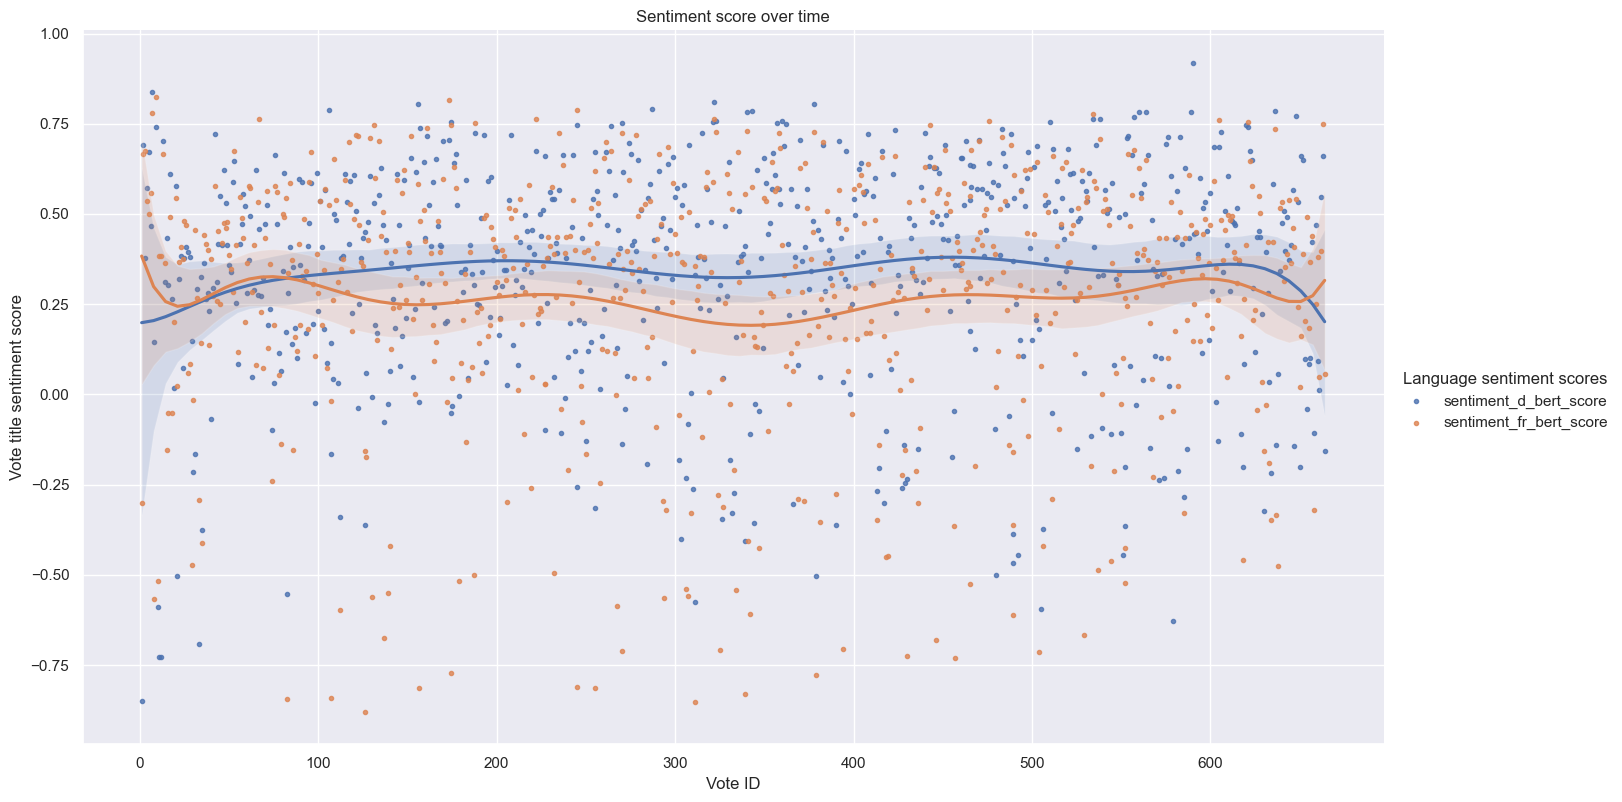

In [39]:
g = sns.lmplot(x='anr', y='vals', data=dfm_sentiment, hue='cols', order=10, scatter=True, markers=[".", "."], height=8, aspect=1.7777777)
g.set_ylabels('Vote title sentiment score')
g.set_xlabels('Vote ID')
g._legend.set_title('Language sentiment scores')
plt.title('Sentiment score over time')
#plt.savefig('./figures/sentiment_bert_lmplot.pdf', format='pdf', bbox_inches='tight')

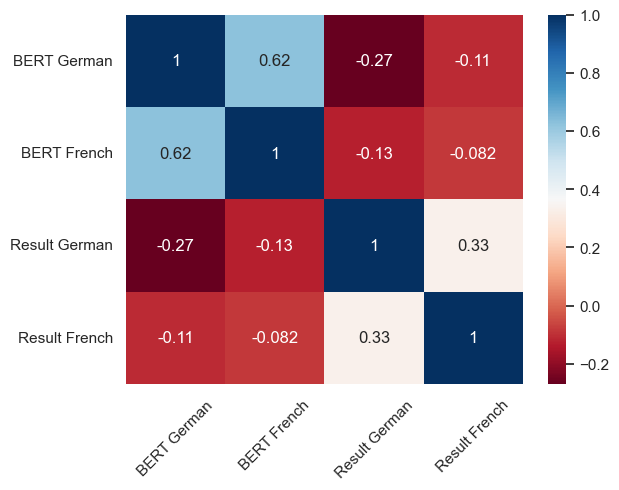

In [36]:
corr_data = text_data[['sentiment_d_bert_score', 'sentiment_fr_bert_score', 'german_outcome', 'french_outcome']].corr()
sns.heatmap(corr_data, annot=True, cmap='RdBu', vmin=-0.27, vmax=1, xticklabels=['BERT German', 'BERT French', 'Result German', 'Result French'], yticklabels=['BERT German', 'BERT French', 'Result German', 'Result French'])
plt.xticks(rotation=45)
#plt.savefig('./figures/sentiment_bert_corr.pdf', format='pdf', bbox_inches='tight')